# Path Finding Algorithm
## Find strongest path with thpt

In [ ]:
pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.9/99.9 kB 8.3 MB/s eta 0:00:00


In [ ]:
# from pyrosm import OSM
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import folium
import heapq

#  출발지 및 목적지 노드 설정 함수 정의
def get_nearest_node(G, latitude, longitude):
    """
    입력된 위도와 경도에 가장 가까운 그래프 노드를 찾는 함수.

    - G: 도로 네트워크 그래프
    - latitude: 위도
    - longitude: 경도

    반환: 가장 가까운 노드 ID
    """
    return ox.distance.nearest_nodes(G, longitude, latitude)

# 최단 경로 탐색 함수 정의
def find_shortest_path(G, origin_point, destination_point):
    """
    입력된 출발지와 목적지 간 최단 경로를 찾는 함수.

    - G: 도로 네트워크 그래프
    - origin_point: 출발지 좌표 (위도, 경도)
    - destination_point: 목적지 좌표 (위도, 경도)

    반환: 최단 경로 노드 리스트
    """
    # # 출발지와 목적지의 가장 가까운 노드 찾기
    # origin_node = get_nearest_node(G, *origin_point)
    # destination_node = get_nearest_node(G, *destination_point)

    # 최단 경로 계산 (Dijkstra 알고리즘)
    shortest_path = nx.shortest_path(G, origin_point, destination_point, weight='length',method="dijkstra") #
    return shortest_path


def plot_route(G, path):
    """
    최단 경로를 그래프에 시각화하는 함수.

    - G: 도로 네트워크 그래프
    - path: 최단 경로 노드 리스트
    """
    if path is None or len(path) == 0:
        print("경로가 유효하지 않아 시각화를 생략합니다.")
        return

    try:
        fig, ax = ox.plot_graph_route(G, path, route_linewidth=2, node_size=0, bgcolor='k')
        plt.show()
    except Exception as e:
        print(f"경로 시각화 중 오류 발생: {e}")


# 도로만 남기는 함수
def create_filtered_graph(G, excluded_highway_types):
    """
    특정 highway 유형을 제외한 새로운 그래프를 반환하는 함수.

    - G: NetworkX 그래프
    - excluded_highway_types: 제외할 highway 유형 리스트 (예: ['footway'])

    반환: 제외된 엣지가 제거된 새로운 NetworkX 그래프
    """
    # 그래프 복사 (원본을 유지하기 위해)
    filtered_graph = G.copy()

    # 제거 대상 엣지 식별 및 제거
    edges_to_remove = [
        (u, v) for u, v, data in filtered_graph.edges(data=True)
        if data.get('highway') in excluded_highway_types
    ]
    filtered_graph.remove_edges_from(edges_to_remove)

    # print(f"Removed {len(edges_to_remove)} edges with highway types: {excluded_highway_types}")
    return filtered_graph

# 도로 네트워크 시각화 함수 정의 (Node ID 표시 추가) - 추가기능
def plot_map_with_node_ids(G, poi_coords=None):
    """
    도로 네트워크와 각 노드의 ID를 시각화하는 함수.

    - G: 도로 네트워크 그래프
    - poi_coords: POI 위치 좌표 리스트 (선택적)
    """
    # 도로 네트워크 시각화
    fig, ax = ox.plot_graph(G, show=False, close=False)

    i = 1
    # 각 노드의 위치에 Node ID를 표시
    for node, data in G.nodes(data=True):
        x, y = data['x'], data['y']
        if node == 10666146667 or node == 9274780719:
            ax.text(x, y, str(node), fontsize=8, color='blue')  # Node ID 표시

    # POI 위치 시각화 (있을 경우)
    if poi_coords:
        y, x = zip(*poi_coords)
        ax.scatter(x, y, c='red', s=30, label='POI')
        ax.legend()

    plt.show()

# throughput 데이터를 노드에 매핑하는 함수 정의
def map_throughput_to_nodes(G, throughput_excel):
    """
    throughput 데이터를 그래프 노드 속성으로 매핑하는 함수.

    - G: 도로 네트워크 그래프
    - throughput_excel: 노드 ID와 throughput 값을 가진 DataFrame

    반환: throughput 속성이 추가된 그래프
    """
    # 노드 ID를 문자열로 변환하여 통일
    throughput_excel['Node ID'] = throughput_excel['Node ID'].astype(str)

    for node, data in G.nodes(data=True):
        # 그래프 노드 ID도 문자열로 변환
        node_str = str(node)
        # 노드 ID와 일치하는 Throughput 값을 찾음
        throughput_value = throughput_excel.loc[throughput_excel['Node ID'] == node_str, 'Throughput(Mbps)'].values
        if len(throughput_value) > 0:
            G.nodes[node]['throughput'] = throughput_value[0]  # Throughput 값을 노드에 추가
        else:
            G.nodes[node]['throughput'] = 0  # 데이터가 없을 경우 0으로 설정
    return G






# thpt을 가중치로 하여 신호 세기가 강한 경로를 찾는 알고리즘 함수 생성

In [ ]:
# 누적 가중치를 고려한 함수
def find_strongest_path(G, source, target):
    """
    Dijkstra 알고리즘을 수정하여 누적 가중치를 고려한 경로를 찾는 함수.

    - G: NetworkX 그래프
    - source: 출발 노드
    - target: 도착 노드

    반환:
    - 최단 경로의 노드 리스트
    - 경로의 누적 가중치
    """
    # 우선순위 큐 초기화 (누적 가중치 기준)
    queue = [(0, source, [])]  # (누적 가중치, 현재 노드, 경로)
    visited = set()

    while queue:
        cum_weight, current_node, path = heapq.heappop(queue)

        # 이미 방문한 노드는 무시
        if current_node in visited:
            continue
        visited.add(current_node)

        # 현재 노드를 경로에 추가
        path = path + [current_node]

        # 목표 노드에 도달하면 결과 반환
        if current_node == target:
            return path, cum_weight

        # 인접 노드 탐색
        for neighbor in G.neighbors(current_node):
            edge_data = G[current_node][neighbor]

            # 최소 가중치 선택 (다중 간선 고려)
            min_edge_weight = float('inf')
            for key, data in edge_data.items():
                edge_weight = data.get('weight', float('inf'))
                if edge_weight is not None:
                    min_edge_weight = min(min_edge_weight, edge_weight)

            # 최소 가중치를 기반으로 경로 확장
            if min_edge_weight < float('inf'):
                new_cum_weight = cum_weight + min_edge_weight
                heapq.heappush(queue, (new_cum_weight, neighbor, path))

    return None, float('inf')




# 가중치 계산 함수
def calculate_weight(throughput, distance, ratio):
    """
    - Throughput : Throughput 값
    - distance   : distance 값
    - ratio      : Throughput과 거리의 비율 (0~1)

    """
    # 최종 가중치 계산
    weight = (ratio * throughput) + ((1 - ratio) * distance)
    return weight



# 간선 가중치 설정 함수
def set_edge_weights_based_on_ratio(G, ratio):
    """
    간선의 가중치를 두 노드의 throughput 값과 거리 값의 비율로 설정하는 함수.
    - G: 도로 네트워크 그래프
    - ratio: Throughput:Distance 비율 (0~1)
    """

    for u, v, data in G.edges(data=True):
        # 노드의 throughput 값을 가져옴 (없으면 0으로 설정)
        throughput_u = G.nodes[u].get('throughput', 0)
        throughput_v = G.nodes[v].get('throughput', 0)
        distance = data.get('length', float('inf'))

        # 두 노드의 throughput 평균 계산
        avg_throughput = (throughput_u + throughput_v) / 2
        weight = calculate_weight(avg_throughput, distance, ratio)
        data['weight'] = weight
    return G


- 충북대 osm 불러오기 및 src, target 지정

출발지 노드 ID (청주 시외버스터미널): 8485871892
목적지 노드 ID (충북대학교 병원): 6200628380


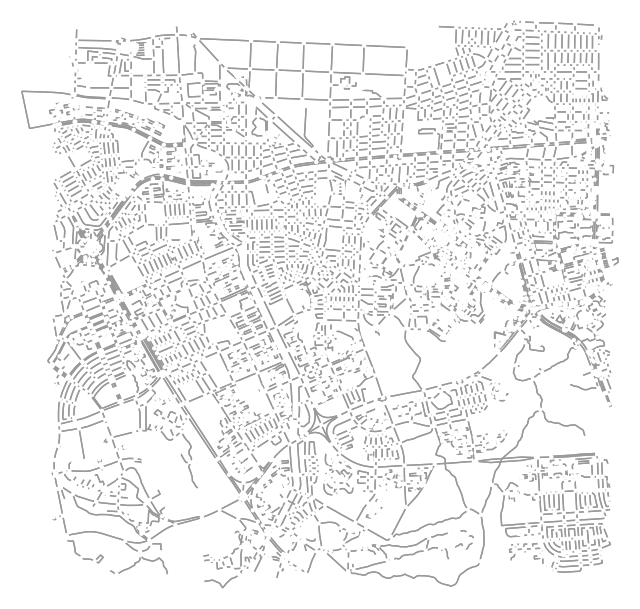

In [ ]:
# 출발지 및 목적지 좌표 설정
origin = (36.6256453, 127.4314837)        # 청주 시외버스터미널
destination = (36.6246818, 127.4638686)   # 충북대학교 병원

# 중심 좌표 계산 (중간 지점)
center_lat = (origin[0] + destination[0]) / 2
center_lon = (origin[1] + destination[1]) / 2
center_point = (center_lat, center_lon)

# 반경 2km 도로 네트워크 불러오기
radius = 2000  # 반경 2km
cheongju_graph = ox.graph_from_point(center_point, dist=radius, network_type="walk")

# 출발지와 목적지의 가장 가까운 노드 찾기
origin_node = get_nearest_node(cheongju_graph, *origin)
destination_node = get_nearest_node(cheongju_graph, *destination)

print(f"출발지 노드 ID (청주 시외버스터미널): {origin_node}")
print(f"목적지 노드 ID (충북대학교 병원): {destination_node}")

# 시각화로 반경 확인
fig, ax = ox.plot_graph(cheongju_graph, bgcolor='white', node_size=10, edge_linewidth=1)

In [ ]:
## 도보 제외한 네트워크 Graph 생성
# 제외할 highway 유형 설정
excluded_highways = ['footway']

# 필터링된 그래프 생성
filtered_graph = create_filtered_graph(cheongju_graph, excluded_highways)

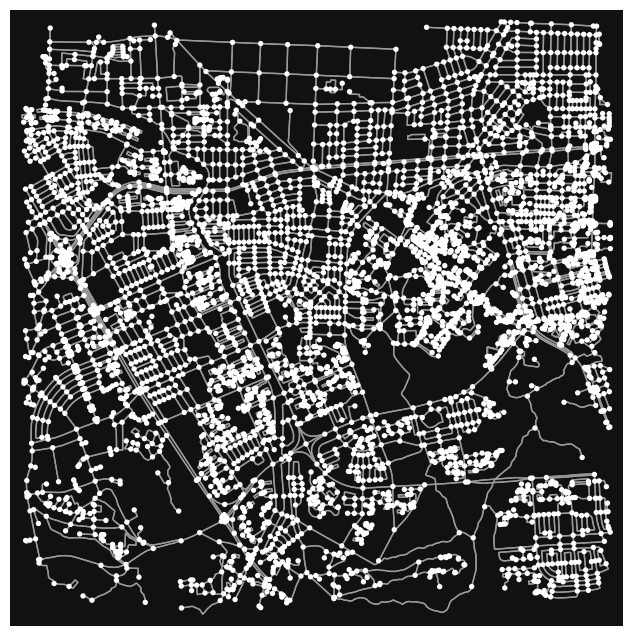

In [ ]:
plot_map_with_node_ids(filtered_graph)

- rxsite 노드 ID 반환 코드

## 유효 노드

- 교차로의 노드 & 출발지/목적지 노드만 표현

In [ ]:
# 단계 1 : 기본 유효 노드 집합 생성
# Rx 노드 ID 불러오기
rx_file_path = 'rxsite_throughput_with_node_id.xlsx'
rx_data = pd.read_excel(rx_file_path)
rx_node_ids = rx_data['Node ID'].tolist()

# 출발지, 목적지, Rx 노드 ID 합치기
valid_node_ids = set(rx_node_ids + [origin_node, destination_node])

# 출발지 및 목적지 좌표 설정
origin = (36.6256453, 127.4314837)        # 청주 시외버스터미널
destination = (36.6246818, 127.4638686)   # 충북대학교 병원

# 출발지와 목적지의 가장 가까운 노드 찾기
origin_node = ox.distance.nearest_nodes(cheongju_graph, origin[1], origin[0])
destination_node = ox.distance.nearest_nodes(cheongju_graph, destination[1], destination[0])



# # Rx 노드만 포함된 독립 그래프 생성
# rx_graph = nx.Graph()
# for _, row in rx_data.iterrows():
#     node_id = row['Node ID']
#     lat, lon = row['RxLatitude'], row['RxLongitude']
#     rx_graph.add_node(node_id, x=lon, y=lat)


# # 출발지, 목적지, Rx 노드만 포함하는 필터링된 그래프 생성
# node_filtered_graph = cheongju_graph.subgraph(valid_node_ids).copy()




In [ ]:
# 단계 2 : 출발지와 목적지 간 연결성 확인
try:
    # 직접 경로가 있는지 확인
    nx.shortest_path(cheongju_graph, origin_node, destination_node, weight='length')
    print("출발지와 목적지가 직접 연결되어 있습니다.")
except nx.NetworkXNoPath:
    print("출발지와 목적지가 직접 연결되어 있지 않습니다.")


출발지와 목적지가 직접 연결되어 있습니다.


In [ ]:
# 단계 3: 중간 노드를 포함하여 경로 확장
def expand_valid_nodes(G, start_node, valid_nodes):
    """
    출발지로부터 연결된 모든 유효 노드를 탐색하여 확장합니다.
    """
    expanded_nodes = set(valid_nodes)
    queue = [start_node]
    visited = set()

    while queue:
        current_node = queue.pop(0)
        if current_node in visited:
            continue
        visited.add(current_node)

        # 인접 노드 탐색
        for neighbor in G.neighbors(current_node):
            if neighbor not in expanded_nodes:
                expanded_nodes.add(neighbor)
                queue.append(neighbor)

    return expanded_nodes

# 출발지와 목적지로부터 확장된 유효 노드 집합 생성
expanded_nodes = expand_valid_nodes(cheongju_graph, origin_node, valid_node_ids)
expanded_nodes = expand_valid_nodes(cheongju_graph, destination_node, expanded_nodes)

# 확장된 노드로 서브그래프 생성
expanded_graph = cheongju_graph.subgraph(expanded_nodes).copy()


In [ ]:
# 단계 4: 확장 그래프를 사용하여 경로 탐색

try:
    # 최단 경로 탐색
    shortest_path = nx.shortest_path(expanded_graph, origin_node, destination_node, weight='length')
    print("최단 경로:", shortest_path)
except nx.NetworkXNoPath:
    print("확장 그래프에서도 경로를 찾을 수 없습니다.")


최단 경로: [8485871892, 8485871893, 4679820440, 4679820439, 5370128281, 3015872402, 2272245177, 3791819479, 1621248629, 2271378269, 4656734353, 1621248648, 2629876040, 3000023776, 4656882267, 4656882268, 2629876034, 4656897933, 4657017753, 2629876029, 2629876026, 2629876025, 3000023440, 3000023449, 4657089158, 3000023446, 4657056742, 3000023433, 2629876024, 3000023743, 3000023744, 4655491515, 4655491514, 4655491509, 4492202733, 4501568424, 4655490525, 4655490527, 4397573134, 4397573127, 4397573146, 4397573179, 4397573143, 4397573186, 3958352355, 4397573197, 4397573199, 4403766744, 4655491016, 4631157953, 3958352364, 4403766743, 4658273118, 4658273120, 4403766739, 4403766752, 4727599763, 4403766753, 4727599751, 4631209791, 8973274222, 8973274223, 4727599753, 8973274218, 4631209800, 4727599754, 4496854212, 4727599759, 3958352335, 6200628380]


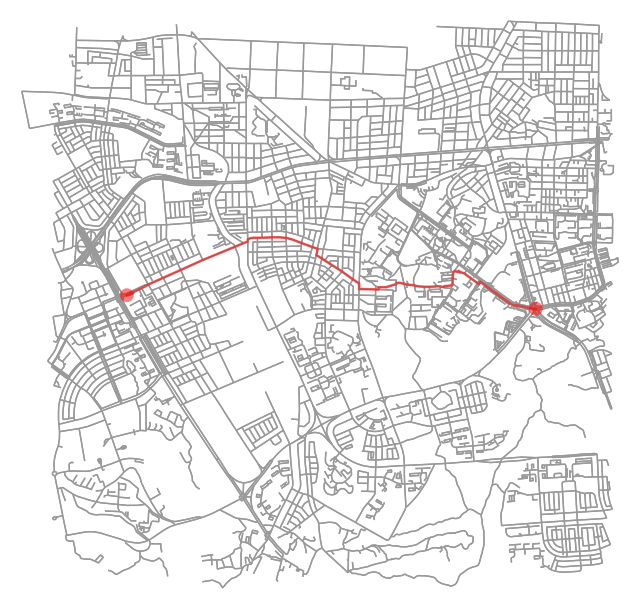

In [ ]:
# 단계 5: 경로 시각화

def plot_route(G, path):
    if path is None:
        print("경로가 유효하지 않아 시각화를 생략합니다.")
        return
    try:
        fig, ax = ox.plot_graph_route(G, path, route_linewidth=2, node_size=0, bgcolor='white')
        plt.show()
    except Exception as e:
        print(f"경로 시각화 중 오류 발생: {e}")

# 경로 시각화
plot_route(expanded_graph, shortest_path)


- Rx, 출발지, 목적지 노드 표시

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45348 (\N{HANGUL SYLLABLE NE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50892 (\N{HANGUL SYLLABLE WEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loc

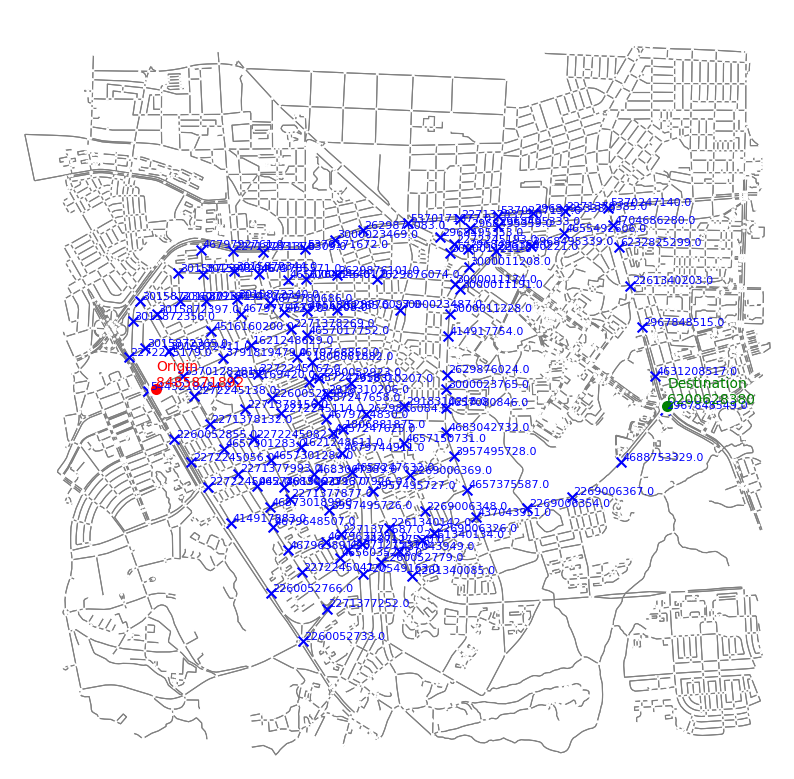

In [ ]:
# OSMnx + Matplotlib 빠른 시각화
def plot_fast_graph(G, rx_graph, origin_node, destination_node):
    fig, ax = plt.subplots(figsize=(10, 10))

    # 도로 네트워크 시각화
    ox.plot_graph(G, ax=ax, node_size=5, node_color='white', edge_color='gray', edge_linewidth=0.8, show=False, close=False, bgcolor='black')

    # Rx 노드 시각화
    for node in rx_graph.nodes:
        x, y = rx_graph.nodes[node]['x'], rx_graph.nodes[node]['y']
        ax.scatter(x, y, c='blue', s=50, marker='x')
        ax.text(x + 0.0001, y + 0.0001, str(node), fontsize=8, color='blue')

    # 출발지 노드 표시
    x, y = G.nodes[origin_node]['x'], G.nodes[origin_node]['y']
    ax.scatter(x, y, c='red', s=100, label='Origin', marker='o', edgecolors='white', linewidths=2)
    ax.text(x, y, f'Origin\n{origin_node}', fontsize=10, color='red', ha='left', va='bottom')

    # 목적지 노드 표시
    x, y = G.nodes[destination_node]['x'], G.nodes[destination_node]['y']
    ax.scatter(x, y, c='green', s=100, label='Destination', marker='o', edgecolors='white', linewidths=2)
    ax.text(x, y, f'Destination\n{destination_node}', fontsize=10, color='green', ha='left', va='bottom')

    plt.title("도로 네트워크와 Rx 노드 시각화 (OSMnx + Matplotlib)", color='white', fontsize=14)
    plt.show()

# 시각화 실행
plot_fast_graph(cheongju_graph, rx_graph, origin_node, destination_node)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54952 (\N{HANGUL SYLLABLE HYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45432 (\N{HANGUL SYLLABLE NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/loc

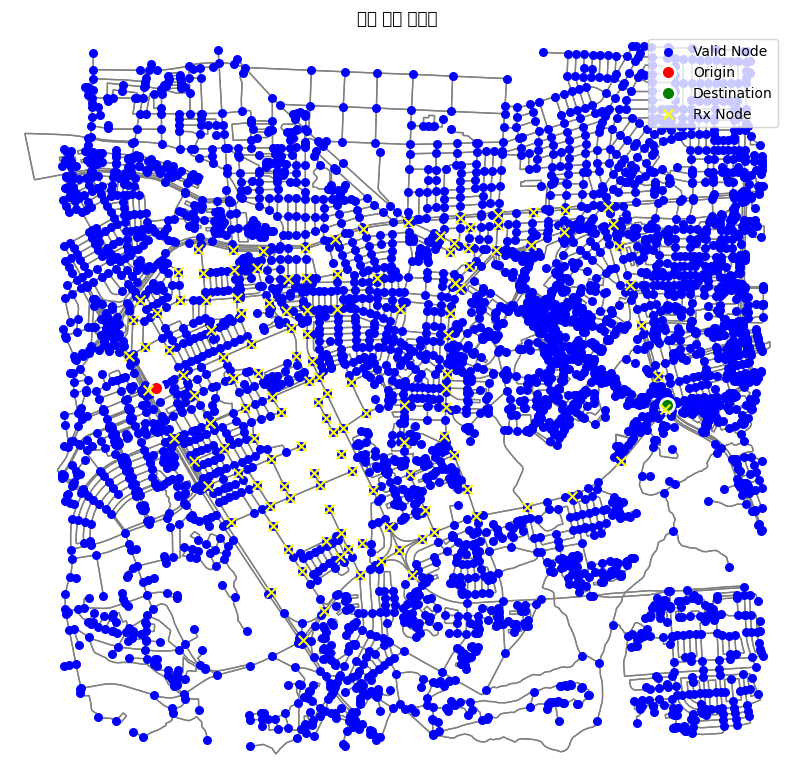

In [ ]:
def plot_valid_nodes(G, valid_nodes, origin_node, destination_node):
    """
    유효 노드를 시각화하는 함수

    - G: 그래프 (NetworkX 그래프)
    - valid_nodes: 유효 노드 ID 리스트
    - origin_node: 출발지 노드 ID
    - destination_node: 목적지 노드 ID
    """
    fig, ax = plt.subplots(figsize=(10, 10))

    # 그래프 시각화
    ox.plot_graph(G, ax=ax, node_size=5, node_color='lightgray', edge_color='gray', show=False, close=False)

    # 유효 노드 시각화
    for node in valid_nodes:
        x, y = G.nodes[node]['x'], G.nodes[node]['y']
        ax.scatter(x, y, c='blue', s=30, marker='o', label='Valid Node' if node == list(valid_nodes)[0] else "")

    # 출발지 노드 시각화
    x, y = G.nodes[origin_node]['x'], G.nodes[origin_node]['y']
    ax.scatter(x, y, c='red', s=100, marker='o', label='Origin', edgecolors='white', linewidths=2)

    # 목적지 노드 시각화
    x, y = G.nodes[destination_node]['x'], G.nodes[destination_node]['y']
    ax.scatter(x, y, c='green', s=100, marker='o', label='Destination', edgecolors='white', linewidths=2)

    # Rx 노드 시각화
    for node in rx_node_ids:
        if node in G.nodes:
            x, y = G.nodes[node]['x'], G.nodes[node]['y']
            ax.scatter(x, y, c='yellow', s=50, marker='x', label='Rx Node' if node == rx_node_ids[0] else "")

    plt.title("유효 노드 시각화")
    plt.legend(loc='upper right')
    plt.show()

# 유효 노드 시각화 호출
plot_valid_nodes(expanded_graph, expanded_nodes, origin_node, destination_node)


- 노드 좌표 저장 코드

In [35]:
import pandas as pd

def save_node_coordinates_to_excel(G, file_name='node_coordinates.xlsx'):
    """
    그래프의 모든 노드 좌표를 엑셀 파일로 저장하는 함수

    - G: NetworkX 그래프
    - file_name: 저장할 엑셀 파일 이름 (기본값: 'node_coordinates.xlsx')
    """
    # 노드 정보를 저장할 리스트 초기화
    node_data = []

    # 모든 노드의 좌표를 추출하여 리스트에 추가
    for node, data in G.nodes(data=True):
        try:
            x, y = data['x'], data['y']
            node_data.append([node, x, y])
        except KeyError:
            print(f"노드 {node}의 좌표가 없습니다.")

    # 데이터프레임으로 변환
    df = pd.DataFrame(node_data, columns=['Node ID', 'Longitude', 'Latitude'])

    # 엑셀 파일로 저장
    df.to_excel(file_name, index=False)
    print(f"모든 노드 좌표가 '{file_name}' 파일에 저장되었습니다.")

# 그래프를 불러온 후 사용
save_node_coordinates_to_excel(expanded_graph, 'all_nodes_coordinates.xlsx')


모든 노드 좌표가 'all_nodes_coordinates.xlsx' 파일에 저장되었습니다.


## Thpt 활용하여 위의 과정 반복

- thpt dataset 불러오기


[거리 중심 (0:1)]



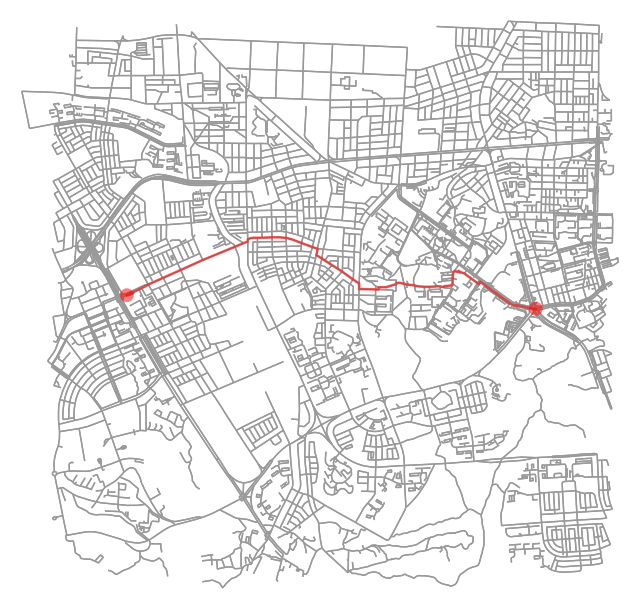

비율 거리 중심 (0:1) 경로: [8485871892, 8485871893, 4679820440, 4679820439, 5370128281, 3015872402, 2272245177, 3791819479, 1621248629, 2271378269, 4656734353, 1621248648, 2629876040, 3000023776, 4656882267, 4656882268, 2629876034, 4656897933, 4657017753, 2629876029, 2629876026, 2629876025, 3000023440, 3000023449, 4657089158, 3000023446, 4657056742, 3000023433, 2629876024, 3000023743, 3000023744, 4655491515, 4655491514, 4655491509, 4492202733, 4501568424, 4655490525, 4655490527, 4397573134, 4397573127, 4397573146, 4397573179, 4397573143, 4397573186, 3958352355, 4397573197, 4397573199, 4403766744, 4655491016, 4631157953, 3958352364, 4403766743, 4658273118, 4658273120, 4403766739, 4403766752, 4727599763, 4403766753, 4727599751, 4631209791, 8973274222, 8973274223, 4727599753, 8973274218, 4631209800, 4727599754, 4496854212, 4727599759, 3958352335, 6200628380]

경로를 거치는 노드의 수: 70 개
경로의 누적 가중치: 3408.015128217602



[Throughput: 거리  (0.3:0.7)]



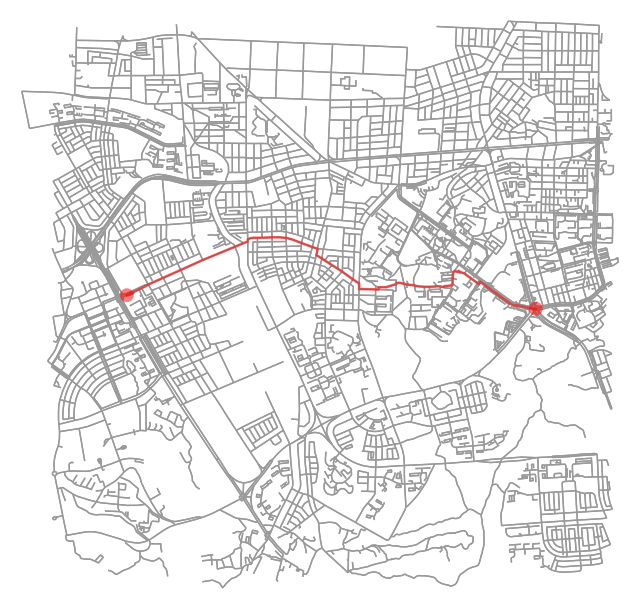

비율 Throughput: 거리  (0.3:0.7) 경로: [8485871892, 8485871893, 4679820440, 4679820439, 5370128281, 3015872402, 2272245177, 3791819479, 1621248629, 2271378269, 4656734353, 1621248648, 2629876040, 3000023776, 4656882267, 4656882268, 2629876034, 4656897933, 4657017753, 2629876029, 2629876026, 2629876025, 3000023440, 3000023449, 4657089158, 3000023446, 4657056742, 3000023433, 2629876024, 3000023743, 3000023744, 4655491515, 4655491514, 4655491509, 4492202733, 4501568424, 4655490525, 4655490527, 4397573134, 4397573127, 4397573146, 4397573179, 4397573143, 4397573186, 3958352355, 4397573197, 4397573199, 4403766744, 4655491016, 4631157953, 3958352364, 4403766743, 4658273118, 4658273120, 4403766739, 4403766752, 4727599763, 4403766753, 4727599751, 4631209791, 8973274222, 8973274223, 4727599753, 8973274218, 4631209800, 4727599754, 4496854212, 4727599759, 3958352335, 6200628380]

경로를 거치는 노드의 수: 70 개
경로의 누적 가중치: 2600.091983909899



[Throughput: 거리  (0.6:0.4)]



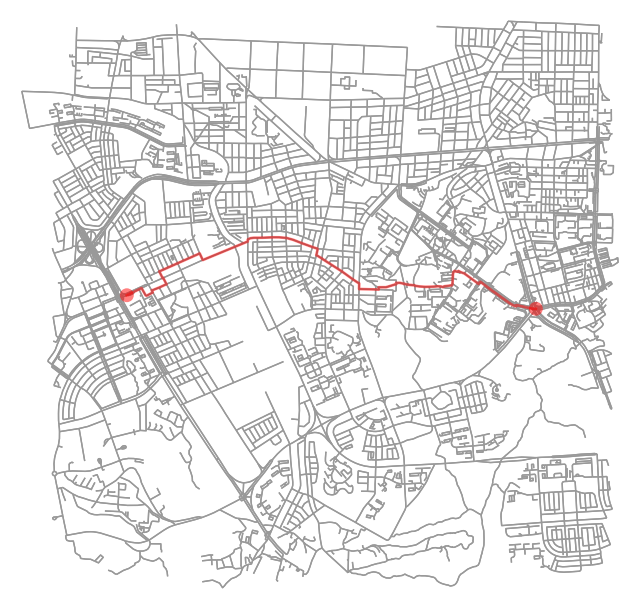

비율 Throughput: 거리  (0.6:0.4) 경로: [8485871892, 8485871893, 4679820440, 4679820439, 4679820432, 2272245158, 2272245162, 2272245164, 2272245177, 3015872402, 3015872401, 4516160212, 4516160214, 4516160216, 4516160207, 4516160206, 4516160204, 4516160202, 3670764371, 1621248629, 2271378269, 4656734353, 1621248648, 2629876040, 3000023776, 4656882267, 4656882268, 2629876034, 4656897933, 4657017753, 2629876029, 2629876026, 2629876025, 3000023440, 3000023449, 4657089158, 3000023446, 4657056742, 3000023433, 2629876024, 3000023743, 3000023744, 4655491515, 4655491514, 4655491509, 4492202733, 4501568424, 4655490525, 4655490527, 4397573134, 4397573127, 4397573146, 4397573179, 4397573143, 4397573186, 3958352355, 4397573197, 4397573199, 4403766744, 4655491016, 4631157953, 3958352364, 4403766743, 4658273118, 4658273120, 4403766739, 4403766752, 4727599763, 4403766753, 4727599751, 4631209791, 8973274222, 8973274223, 4727599753, 8973274218, 4631209800, 4727599754, 4496854212, 4727599759, 3958352335, 620062

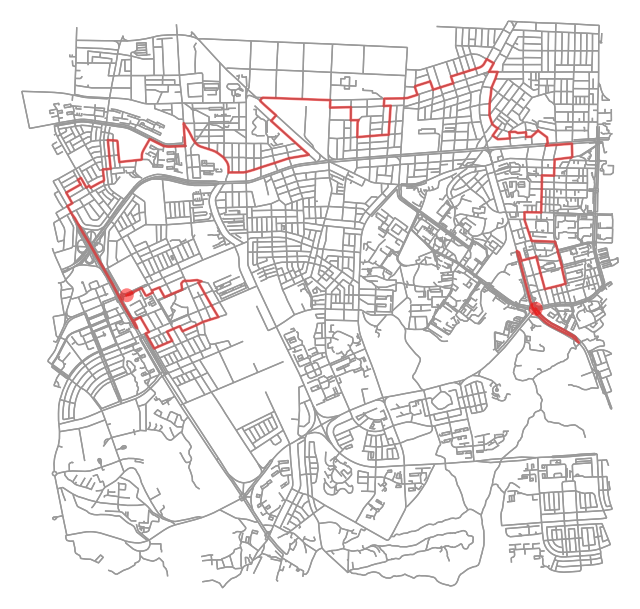

비율 Throughput: 거리  (1:0) 경로: [8485871892, 8485871893, 4679820440, 4679820439, 4679820432, 2272245158, 2272245162, 2272245145, 2272245153, 2272245161, 2272245174, 2272245171, 2272245169, 2272245155, 4657169421, 2272245110, 2272245107, 2272245100, 2272245096, 2272245089, 2272245094, 4657301287, 2272245088, 2272245074, 2272245069, 2272245067, 2272245063, 2272245061, 2272245076, 2272245086, 2272245087, 2272245109, 2272245105, 2260052868, 2260053068, 2260053114, 2260053119, 4658184048, 4658184059, 3015836780, 3015849445, 3015849447, 3015849448, 3015849450, 3015849451, 3015849446, 3015849456, 3015849459, 3015849468, 3015849466, 3015849460, 3015836806, 3015836790, 3015836788, 3015836787, 3015836800, 3015836809, 3015836828, 3015836829, 3015836826, 3015836821, 3015801389, 2268029093, 3015799894, 3015801371, 3015801369, 3015799926, 3015799884, 3015799881, 3015799871, 3015799874, 3015801357, 3015801354, 3015799901, 3015801333, 3015799899, 3015799898, 3015799897, 3015799895, 3015799856, 3015799857

In [ ]:
# 엑셀 comm data(throughput) 불러오기
throughput_excel = pd.read_excel('rxsite_throughput_with_node_id.xlsx')

# throughput 정보를 노드에 매핑
G_set_node = map_throughput_to_nodes(expanded_graph, throughput_excel)

# comm data가 들어간 최종적인 네트워크 graph 생성
ratios = [0, 0.3, 0.6, 1]
titles = [
    "거리 중심 (0:1)",
    f'Throughput: 거리  ({ratios[1]}:{1-ratios[1]})',
    f'Throughput: 거리  ({ratios[2]}:{1-ratios[2]})',
    f'Throughput: 거리  ({ratios[3]}:{1-ratios[3]})'
]

# 경로 및 시각화
for ratio, title in zip(ratios, titles):
    # 비율에 따라 가중치 설정
    G_complete = set_edge_weights_based_on_ratio(G_set_node, ratio)

    # 경로 탐색
    try:
        strongest_path, avg_weight = find_strongest_path(G_complete, origin_node, destination_node)

        # 경로 유효성 검사
        if strongest_path is None:
            print(f"\n[{title}]\n경로를 찾을 수 없습니다.")
            print("\n============================================================================================================================\n")
            continue

        # 경로 시각화
        print(f"\n[{title}]\n")
        plot_route(G_complete, strongest_path)

        # 경로 정보 출력
        print(f"비율 {title} 경로: {strongest_path}\n")

        # 최단 경로를 거치는 모든 노드 수
        num_nodes_in_path = len(strongest_path)
        print(f"경로를 거치는 노드의 수: {num_nodes_in_path} 개")
        print(f"경로의 누적 가중치: {avg_weight}")
        print("\n============================================================================================================================\n")

    except Exception as e:
        print(f"\n[{title}]\n경로 탐색 중 오류 발생: {e}")
        print("\n============================================================================================================================\n")


- 정리표